https://github.com/mafda/generative_adversarial_networks_101/blob/master/src/cifar10/02_DCGAN_CIFAR10.ipynb

# Dependencies

In [6]:
!pip install tensorflow==1.15

In [7]:
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Conv1D, Conv2D, Conv2DTranspose
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np
import tensorflow as tf

# GAN

In [14]:
class GAN():
  def __init__(self):
    self.img_rows = 32
    self.img_cols = 32
    self.channels = 3
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 128
    optimizer = Adam(0.0002, 0.5) 
    self.discriminator = self.build_discriminator()

    self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
    self.generator = self.build_generator()

    z = Input(shape=(self.latent_dim,))

    img= self.generator(z)

    self.discriminator.trainable = False

    validity = self.discriminator(img)

    self.combined = Model(z, validity)
    self.combined.compile(loss='binary_crossentropy', optimizer=optimizer , metrics=['accuracy'])
    
  def build_generator(self):
    model = Sequential()
    model.add(Dense(2*2*512, input_shape=(self.latent_dim,)))
    model.add(Reshape((2, 2, 512)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(64, kernel_size=5, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(3, kernel_size=5, strides=2, padding='same', activation='tanh'))

    model.add(Dense(np.prod(self.img_shape), activation='tanh'))
    model.add(Reshape(self.img_shape))
    model.summary()

    noise = Input(shape=(self.latent_dim,))
    img = model(noise)
    return Model(noise, img)
        

  def build_discriminator(self):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=(self.img_shape)))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.summary()
    img = Input(shape=self.img_shape)
    validity = model(img)
    return Model(img, validity)


  def train(self, epochs, batch_size, sample_interval):
    (X_train, _), (_, _) = cifar10.load_data()
    
    X_train = np.float32(X_train)
    X_train = (X_train / 255.)
    #X_train = (X_train / 127.5 - 1) * 2
    X_train = np.clip(X_train, -1, 1)

    print('X_train shape:', X_train.shape)

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      imgs = X_train[idx]
        
      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
      gen_imgs = self.generator.predict(noise)

      d_loss_real = self.discriminator.train_on_batch(imgs, valid)

      d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)

      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

      #real_data_discrimination = []
      #for i in range(0,len(imgs)):
      #  real_data_discrimination.append(1/(np.linalg.norm(imgs[0])))
      #real_data_discrimination = np.array(real_data_discrimination)

      #g_loss = self.combined.train_on_batch(noise, [valid,real_data_discrimination])
      
      g_loss = self.combined.train_on_batch(noise, valid)
      
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f, G acc.: %.2f%%]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], 100*g_loss[1]))
      #if epoch % sample_interval == 0:
       # self.sample_images(epoch)

  #def sample_images(self, epoch):
   # r, c = 5, 5
    #noise = np.random.normal(0, 1, (r * c, self.latent_dim))
    #gen_imgs = self.generator.predict(noise)
    #gen_imgs = 0.5 * gen_imgs + 0.5
    #fig, axs = plt.subplots(r, c)
    #cnt = 0
    #for i in range(r):
    #  for j in range(c):
    #    axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
    #    axs[i,j].axis('off')
    #    cnt += 1
      #fig.savefig("%d.png" % epoch)
    #  plt.close()

# Train

In [17]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=10000, batch_size=64, sample_interval=100)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_29 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 4, 4, 256)         819456    
_________________________________________________________________
batch_normalization_30 (Batc (None, 4, 4, 256)        

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.886537, acc.: 13.28%] [G loss: 0.017281, G acc.: 100.00%]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
5001 [D loss: 0.001699, acc.: 100.00%] [G loss: 6.162996, G acc.: 0.00%]
5002 [D loss: 0.001921, acc.: 100.00%] [G loss: 6.103168, G acc.: 0.00%]
5003 [D loss: 0.001396, acc.: 100.00%] [G loss: 6.489916, G acc.: 0.00%]
5004 [D loss: 0.001291, acc.: 100.00%] [G loss: 6.319721, G acc.: 0.00%]
5005 [D loss: 0.001370, acc.: 100.00%] [G loss: 6.073945, G acc.: 0.00%]
5006 [D loss: 0.001320, acc.: 100.00%] [G loss: 6.096802, G acc.: 0.00%]
5007 [D loss: 0.001906, acc.: 100.00%] [G loss: 6.378501, G acc.: 0.00%]
5008 [D loss: 0.001372, acc.: 100.00%] [G loss: 5.835950, G acc.: 0.00%]
5009 [D loss: 0.002107, acc.: 100.00%] [G loss: 5.734637, G acc.: 0.00%]
5010 [D loss: 0.001949, acc.: 100.00%] [G loss: 5.757378, G acc.: 0.00%]
5011 [D loss: 0.001007, acc.: 100.00%] [G loss: 6.081539, G acc.: 0.00%]
5012 [D loss: 0.001838, acc.: 100.00%] [G loss: 5.993981, G acc.: 0.00%]
5013 [D loss: 0.001518, acc.: 100.00%] [G loss: 5.791278, G acc.: 0.00%]


# Visualize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

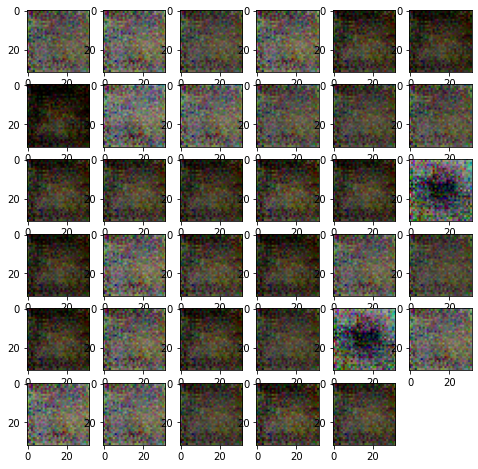

In [18]:
noise = np.random.normal(0, 1, (36,128))
gen_imgs = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 6

for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow(gen_imgs[i])
    
plt.show()

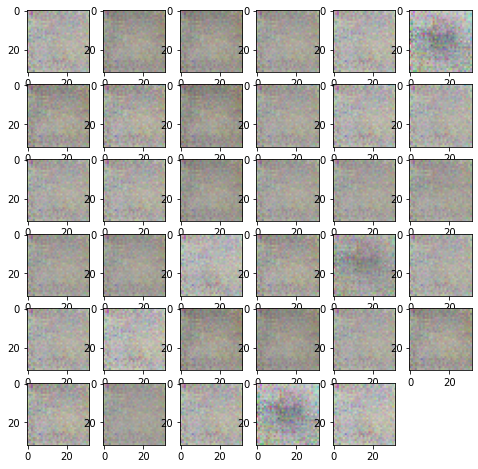

In [19]:
noise = np.random.normal(0, 1, (36,128))
gen_imgs = gan.generator.predict(noise)
gen_imgs.shape


fig = plt.figure(figsize=(8, 8))
columns = 6
rows = 6
for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow(((gen_imgs[i] + 1)* 127).astype(np.uint8))
plt.show()

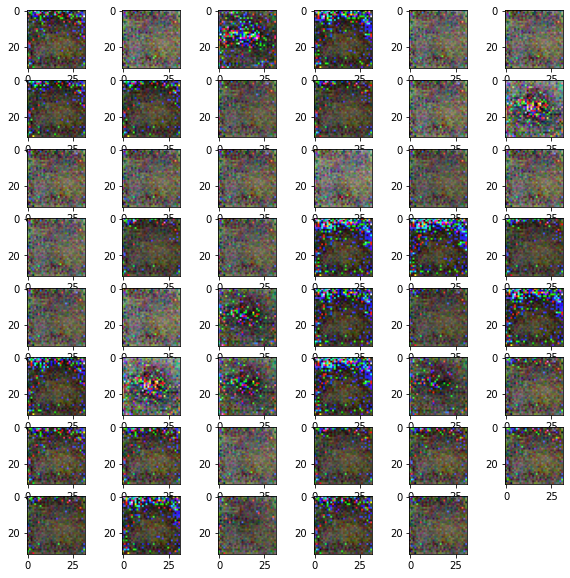

In [20]:
noise = np.random.normal(0, 1, (48,128))
gen_imgs  = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(10, 10))
columns = 6
rows = 8

for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow((gen_imgs[i] * 255).astype(np.uint8))
plt.show()

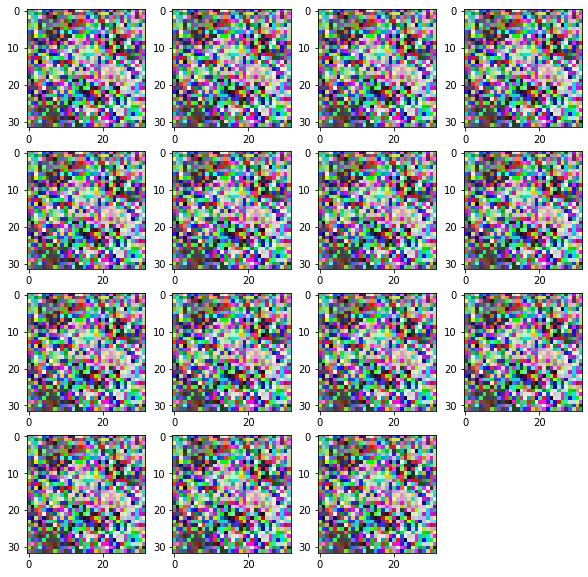

In [ ]:
noise = np.random.normal(0, 1, (16,128))
gen_imgs  = gan.generator.predict(noise)
gen_imgs.shape

fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 4
for i in range(1, columns*rows):
    fig.add_subplot(rows, columns, i)
    plt.imshow((gen_imgs[i] * 255).astype(np.uint8))
plt.show()